In [18]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

In [32]:

# Load audio file
    # y = time series representation of audio
    # sr = sample rate, None is original sample rate.
def load_audio(file_path, duration_sec):
    y, sr = librosa.load(file_path, sr=None, duration=duration_sec)  
    
    return y, sr 
y

array([ 1.9490719e-05,  9.1195107e-06,  6.3776970e-06, ...,
       -1.9339430e-01, -1.9715422e-01, -1.9917697e-01], dtype=float32)

## Sample 

- **A discrete measurement of audio signal's amplitude at specifc moment in time.**
- The array y contains these samples where each element in y is a single measurement of the audio signal.

## Sampling rate  
- **How many samples are captured per second in the audio signal.**
- It is usually measured in Hertz.

---

## Fourier Transform

- **Allows us to decompose signals (sound waves) into basic building blocks—sine waves of different frequencies.**
- It transforms a **time domain** signal into a **frequency domain** representation.

### Time Domain:
- The signal is represented as a **change in amplitude over time**, like the raw audio waveform.

### Frequency Domain:
- The signal is represented by its **constituent frequencies**, showing how much of each frequency is present in the signal.

- [Interactive guide to the Fourier Transform](https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/)

### Limitation:
- The **Fourier Transform loses information about time**: it tells you **what frequencies** are present, but not **when** they occur in the signal.

---


## Short-Time Fourier Transform (STFT)

- **Extends the Fourier Transform** to handle signals whose frequency content changes over time by analyzing **small sections (windows)** of the signal at a time.
- Instead of analyzing the entire signal at once (like the Fourier Transform), **STFT divides the signal into overlapping windows** of fixed length.
- The Fourier Transform is applied to each window separately, capturing both **time** and **frequency** information.
- By sliding the window across the signal, **STFT captures how the frequency content changes over time**.

### Frequency Bins in STFT:
- **Frequencies are evenly spaced**. For example, analyzing frequencies between 0 Hz and 22 kHz, each frequency bin might be spaced by 100 Hz.
- All frequencies are treated equally, whether low or high.

### Example of Frequency Bins in STFT:
- 0 Hz, 100 Hz, 200 Hz, 300 Hz, ... up to 22,000 Hz
---


# Why Use Constant-Q Transform (CQT)?

- In **CQT**, frequencies are **logarithmically spaced**, meaning the spacing between frequency bins **gets wider as the frequencies get higher**.
- This is **how musical notes work**, as each **octave represents a doubling of frequency**.

### Example of Frequency Bins in CQT:
- 32 Hz (C1), 65 Hz (C2), 130 Hz (C3), 261 Hz (C4), 523 Hz (C5), etc.

- The spacing between low frequencies is narrow, but the spacing between high frequencies is wider.


In [20]:
# Compute Constant-Q Transform
def compute_cqt(y, sr):
    # Compute the CQT (with default bins per octave = 12)
    C = librosa.cqt(y, sr=sr)
    # Convert the CQT to decibels for better visualization
    C_dB = librosa.amplitude_to_db(np.abs(C), ref=np.max)
    return C_dB


In [21]:
# Plot CQT
def plot_cqt(C_dB, sr):
    plt.figure(figsize=(10, 6))
    # Use librosa's display functionality to plot the CQT
    librosa.display.specshow(C_dB, sr=sr, x_axis='time', y_axis='cqt_note', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Constant-Q Transform (CQT) Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()


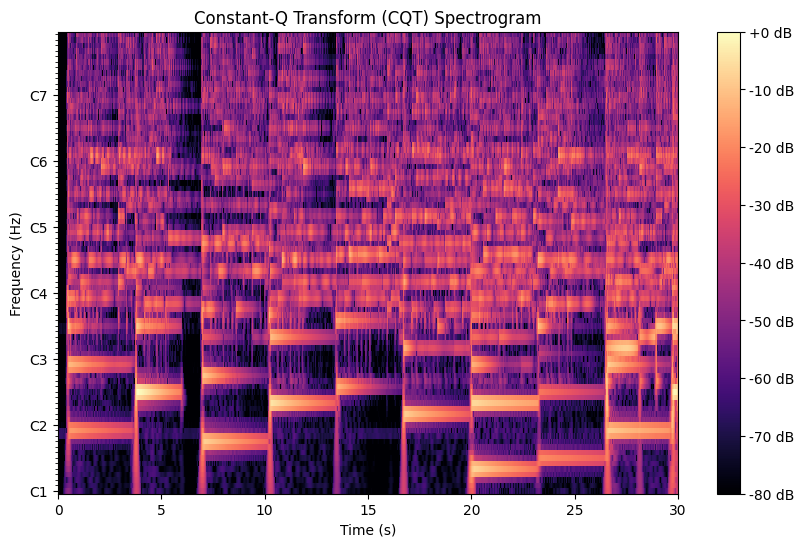

In [22]:

file_path = r"C:\Users\samar\OneDrive\Documents\CS5100\Project\Sample\Hotel_California.wav"
y, sr = load_audio(file_path, duration_sec=30)  
C_dB = compute_cqt(y, sr)  # Compute CQT
plot_cqt(C_dB, sr)  